In [ ]:
!pip install focal_loss

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import new callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Path to your CSV file in Google Colab
CSV_PATH = "/content/donki_flare_dataset_with_wsa.csv"

In [ ]:
# Load the dataset
df = pd.read_csv(CSV_PATH)

# Display the first few rows and basic info
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   active_region_num          cutoff_time  flr_count_6h  flr_count_6h_B  \
0              12253  2014-12-31 09:00:00             0               0   
1              12253  2014-12-31 15:00:00             0               0   
2              12253  2014-12-31 21:00:00             0               0   
3              12253  2015-01-01 03:00:00             0               0   
4              12253  2015-01-01 09:00:00             0               0   

   flr_count_6h_C  flr_count_6h_M  flr_count_6h_X  flr_max_class_ord_6h  \
0               0               0               0                    -1   
1               0               0               0                    -1   
2               0               0               0                    -1   
3               0               0               0                    -1   
4               0               0               0                    -1   

   flr_peak_flux_max_6h  flr_count_12h  ...  sep_present_72h  \
0    

In [ ]:
# Convert 'cutoff_time' to datetime
df['cutoff_time'] = pd.to_datetime(df['cutoff_time'])

# Replace 'inf' in 'flr_time_since_last_peak_min' with a large number
df['flr_time_since_last_peak_min'].replace([np.inf, -np.inf], 1e9, inplace=True)

# Fill any other potential NaN values (using forward fill) for all features first
df.fillna(method='ffill', inplace=True)
# Fill any remaining NaNs (if any at the beginning) with 0
df.fillna(0, inplace=True)

# --- NEW: Re-map '0' and 'B' classes to 'None' ---
# Convert target column to string first to handle any mixed types during replace
df['y_next24h_class_letter'] = df['y_next24h_class_letter'].astype(str)
df['y_next24h_class_letter'] = df['y_next24h_class_letter'].replace(['0', 'B', 'nan'], 'None')
# Note: 'nan' string comes from np.nan being converted to string. We also map this to 'None'.
# Any original pandas NaNs would have been filled with 'None' if .fillna('None') was before .astype(str).
# Here, we do astype(str) first then replace 'nan' string.

# Display updated counts
print("\nTarget class distribution after re-mapping:")
print(df['y_next24h_class_letter'].value_counts())


Target class distribution after re-mapping:
y_next24h_class_letter
M       12286
X        3426
C        3009
None      330
Name: count, dtype: int64


/tmp/ipython-input-2427985309.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['flr_time_since_last_peak_min'].replace([np.inf, -np.inf], 1e9, inplace=True)
/tmp/ipython-input-2427985309.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Encode the target as an ORDINAL label with explicit class order
# We keep only the 4-class setup: ['None','C','M','X']
CLASS_ORDER = ['None', 'C', 'M', 'X']
CLASS_TO_ORD = {c:i for i,c in enumerate(CLASS_ORDER)}

# Filter to those classes only (drop rare 'B' etc.)
df = df[df['y_next24h_class_letter'].isin(CLASS_ORDER)].copy()

# Ordinal target 0..K-1 with order None < C < M < X
y_ord = df['y_next24h_class_letter'].map(CLASS_TO_ORD).astype(int)

# Define features (exclude obvious target/leakage/ids)
features = [col for col in df.columns if col not in [
    'active_region_num', 'y_next24h_class_letter', 'y_next24h_class_ord'
]]
X = df[features]

print("Ordinal mapping used:", CLASS_TO_ORD)
print("y_ord value counts (after filtering):")
print(y_ord.value_counts().sort_index().rename(index=dict(enumerate(CLASS_ORDER))))


Ordinal mapping used: {'None': 0, 'C': 1, 'M': 2, 'X': 3}
y_ord value counts (after filtering):
y_next24h_class_letter
None      330
C        3009
M       12286
X        3426
Name: count, dtype: int64


In [ ]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        # Ensure X is numpy array before slicing for consistency
        Xs.append(X[i:(i + time_steps)].values)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Use 10 previous time steps to predict the next one
X_seq, y_seq = create_sequences(X, y_ord.values, TIME_STEPS) # X is now the unscaled DataFrame
# Note: X_seq will contain raw values at this point. Scaling happens later.

print(f"\nShape of sequential features (X_seq): {X_seq.shape}")
print(f"Shape of sequential target (y_seq): {y_seq.shape}")


Shape of sequential features (X_seq): (19041, 10, 34)
Shape of sequential target (y_seq): (19041,)


In [ ]:
# --- REVISED & IMPROVED: Hybrid Chronological-Stratified Split & Scaling ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd # Import pandas to use .value_counts() and .to_dict()

# Build sequential features from X and y_ord BEFORE the split
# Drop the 'cutoff_time' column from X as it's not a numerical feature for scaling
X_numerical = X.drop('cutoff_time', axis=1)

def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    # Ensure X is numpy array before slicing for consistency
    X_values = X.values if isinstance(X, pd.DataFrame) else X
    y_values = y.values if isinstance(y, pd.Series) else y # Handle Series or array input
    for i in range(len(X_values) - time_steps):
        Xs.append(X_values[i:(i + time_steps)])
        ys.append(y_values[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Use 10 previous time steps to predict the next one
X_seq, y_seq = create_sequences(X_numerical, y_ord, TIME_STEPS) # Use X_numerical and y_ord

print(f"\nShape of sequential features (X_seq): {X_seq.shape}")
print(f"Shape of sequential target (y_seq): {y_seq.shape}")

hold_out_size = int(len(X_seq) * 0.20)
X_train_pool, y_train_pool = X_seq[:-hold_out_size], y_seq[:-hold_out_size]
X_future_pool, y_future_pool = X_seq[-hold_out_size:], y_seq[-hold_out_size:]

# Stratify only within the "future" pool to get a representative recent VAL/TEST
X_val, X_test, y_val, y_test = train_test_split(
    X_future_pool, y_future_pool, test_size=0.50, random_state=42, stratify=y_future_pool
)

X_train, y_train = X_train_pool, y_train_pool

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")

# Show class distribution
from collections import Counter
CLASS_ORDER = ['None', 'C', 'M', 'X']  # keep consistent everywhere
print("\nClass distribution (train/val/test) in ORDINAL ids (0=None,1=C,2=M,3=X):")
for name, yy in [('train', y_train), ('val', y_val), ('test', y_test)]:
    cnt = pd.Series(yy).value_counts(normalize=True).sort_index()
    # Add back missing classes if they don't appear in a split for consistent printing
    for i in range(len(CLASS_ORDER)):
        if i not in cnt.index:
            cnt[i] = 0
    print(name, cnt.sort_index().to_dict())


# --- Build CORAL (ordinal) targets: K-1 binary columns with r_k = 1 if y > k else 0 ---
K = 4  # ['None','C','M','X']

def to_coral_targets(y_int, K):
    y = np.asarray(y_int).astype(int)
    # shape: (N, K-1)
    Y = np.zeros((len(y), K-1), dtype=np.float32)
    for k in range(K-1):
        Y[:, k] = (y > k).astype(np.float32)
    return Y

Y_train_coral = to_coral_targets(y_train, K)
Y_val_coral   = to_coral_targets(y_val,   K)
Y_test_coral  = to_coral_targets(y_test,  K)

print("\nBuilt CORAL targets with shape:")
print("Train:", Y_train_coral.shape, " Val:", Y_val_coral.shape, " Test:", Y_test_coral.shape)

# --- Scaling (fit only on TRAIN) ---
scaler = StandardScaler()
n_samples, T, F = X_train.shape
X_train_2d = X_train.reshape(n_samples*T, F)
X_val_2d   = X_val.reshape(X_val.shape[0]*T, F)
X_test_2d  = X_test.reshape(X_test.shape[0]*T, F)

# Handle potential NaN/inf values before scaling
X_train_2d = np.nan_to_num(X_train_2d, copy=False, nan=0.0, posinf=1e9, neginf=-1e9)
X_val_2d   = np.nan_to_num(X_val_2d,   copy=False, nan=0.0, posinf=1e9, neginf=-1e9)
X_test_2d  = np.nan_to_num(X_test_2d,  copy=False, nan=0.0, posinf=1e9, neginf=-1e9)


X_train_scaled = scaler.fit_transform(X_train_2d).reshape(n_samples, T, F)
X_val_scaled   = scaler.transform(X_val_2d).reshape(X_val.shape[0], T, F)
X_test_scaled  = scaler.transform(X_test_2d).reshape(X_test.shape[0], T, F)

print("\nFeatures successfully scaled on the training portion only.")


Shape of sequential features (X_seq): (19041, 10, 33)
Shape of sequential target (y_seq): (19041,)
Training data shape: (15233, 10, 33)
Validation data shape: (1904, 10, 33)
Test data shape: (1904, 10, 33)

Class distribution (train/val/test) in ORDINAL ids (0=None,1=C,2=M,3=X):
train {0: 0.02107267117442395, 1: 0.16608678526882426, 2: 0.6003413641436355, 3: 0.21249917941311627}
val {0: 0.0, 1: 0.1255252100840336, 2: 0.8245798319327731, 3: 0.04989495798319328}
test {0: 0.0, 1: 0.12605042016806722, 2: 0.8245798319327731, 3: 0.04936974789915966}

Built CORAL targets with shape:
Train: (15233, 3)  Val: (1904, 3)  Test: (1904, 3)

Features successfully scaled on the training portion only.


In [ ]:
'''
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_seq),
                                                 y=y_seq)
class_weights_dict = dict(enumerate(class_weights))

print("\nClass weights to handle imbalance:")
print(class_weights_dict)
'''

'\n# Calculate class weights to handle imbalance\nclass_weights = class_weight.compute_class_weight(\'balanced\',\n                                                 classes=np.unique(y_seq),\n                                                 y=y_seq)\nclass_weights_dict = dict(enumerate(class_weights))\n\nprint("\nClass weights to handle imbalance:")\nprint(class_weights_dict)\n'

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
# --- ORDINAL MODEL: CNN + BiLSTM + Attention + CORAL Head ---
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense, Attention

input_layer = Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))

# 1D CNN feature extractor
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)

# BiLSTM
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.3)(x)

# Additive attention over time
attn_context = Attention()([x, x])  # (batch, T, features)
from tensorflow.keras.layers import GlobalAveragePooling1D
pooled = GlobalAveragePooling1D()(attn_context)

# Dense trunk
x = Dense(128, activation='relu')(pooled)
x = Dropout(0.3)(x)

# CORAL ordinal head: K-1 independent sigmoids (y > k)
K = 4
output_layer = Dense(K-1, activation='sigmoid', name='ordinal_head')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 33)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 64)    │      6,400 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 64)    │     12,352 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 5, 64)     │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 5, 256)    │    197,632 │ max_pooling1d[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 5, 256)    │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 5, 256)    │          0 │ dropout[0][0],    │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ordinal_head        │ (None, 3)         │        387 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 249,667 (975.26 KB)

 Trainable params: 249,667 (975.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.9080 - loss: 0.2214 - val_accuracy: 1.0000 - val_loss: 0.1194 - learning_rate: 0.0010
Epoch 2/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9536 - loss: 0.1240 - val_accuracy: 1.0000 - val_loss: 0.1098 - learning_rate: 0.0010
Epoch 3/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.9868 - loss: 0.1141 - val_accuracy: 1.0000 - val_loss: 0.1182 - learning_rate: 0.0010
Epoch 4/5
477/477 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9859 - loss: 0.1078 - val_accuracy: 1.0000 - val_loss: 0.1252 - learning_rate: 0.0010
Epoch 5/5
474/477 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9950 - loss: 0.0987
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
477/477 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9950 - loss: 0.0987 - val_accuracy: 1.0000 - val_loss: 0.1113 - learning_rate: 0.0010


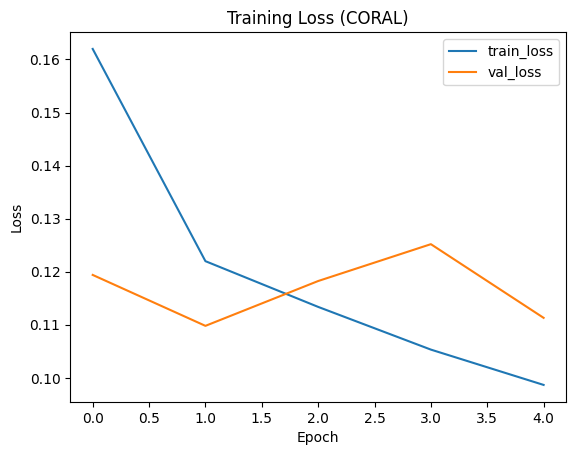

In [ ]:
# --- Compile & Train: CORAL Objective ---
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',   # sum of BCEs over the K-1 thresholds
    metrics=['accuracy']          # (per-threshold; final class metrics computed later)
)

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train_scaled, Y_train_coral,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_scaled, Y_val_coral),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history (loss is most meaningful for CORAL)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training Loss (CORAL)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



Tuned tau* on VAL (objective=macro-F1): tau*=0.375, VAL Acc=0.9086, VAL Macro-F1=0.7118

Classification Report on TEST (ordinal):
              precision    recall  f1-score   support

        None       0.00      0.00      0.00         0
           C       0.89      0.74      0.81       240
           M       0.93      0.97      0.95      1570
           X       0.45      0.32      0.38        94

    accuracy                           0.91      1904
   macro avg       0.57      0.51      0.53      1904
weighted avg       0.90      0.91      0.90      1904



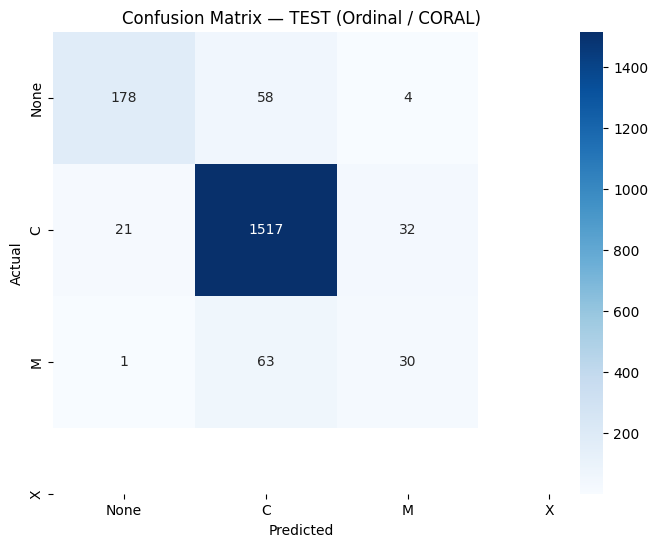

Default tau=0.5 — TEST: Acc=0.9091 | Macro-F1=0.6962


In [ ]:
# --- FINAL EVALUATION (ORDINAL): decode CORAL outputs and tune a single tau on VAL ---
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_ORDER = ['None', 'C', 'M', 'X']
K = 4

def coral_decode(proba_Km1, tau=0.5):
    """Given (N, K-1) sigmoid outputs, return ordinal classes 0..K-1.
       Count how many thresholds are passed (>= tau)."""
    thr_passed = (proba_Km1 >= tau).astype(int).sum(axis=1)
    return thr_passed  # already 0..K-1

# 1) Tune a single tau on the VALIDATION set (optimize macro-F1; switch to accuracy if desired)
proba_val = model.predict(X_val_scaled, verbose=0)
taus = np.linspace(0.30, 0.70, 17)
best = {"tau": None, "macro_f1": -1, "acc": -1}

for tau in taus:
    y_val_pred = coral_decode(proba_val, tau=tau)
    macro = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    acc = accuracy_score(y_val, y_val_pred)
    score = macro  # choose your objective here
    if score > best['macro_f1']:
        best = {"tau": tau, "macro_f1": macro, "acc": acc}

print(f"\nTuned tau* on VAL (objective=macro-F1): tau*={best['tau']:.3f}, "
      f"VAL Acc={best['acc']:.4f}, VAL Macro-F1={best['macro_f1']:.4f}")

# 2) Apply tau* on TEST
proba_test = model.predict(X_test_scaled, verbose=0)
y_test_pred = coral_decode(proba_test, tau=best['tau'])

print("\nClassification Report on TEST (ordinal):")
print(classification_report(
    y_test, y_test_pred,
    target_names=CLASS_ORDER,
    labels=np.arange(K), # Explicitly provide all possible labels
    zero_division=0
))

# Use y_test to get all labels for the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=np.unique(y_test))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_ORDER, yticklabels=CLASS_ORDER)
plt.title('Confusion Matrix — TEST (Ordinal / CORAL)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3) For comparison, also show tau=0.5 default
y_test_pred_05 = coral_decode(proba_test, tau=0.5)
acc05 = accuracy_score(y_test, y_test_pred_05)
macro05 = f1_score(y_test, y_test_pred_05, average='macro', zero_division=0)
print(f"Default tau=0.5 — TEST: Acc={acc05:.4f} | Macro-F1={macro05:.4f}")